In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from result.utils import *
import pickle

# params
save = False
legend = False

# constants
idx = pd.IndexSlice
ws_name = ['woneday', 'w4months', 'w6months']
qs_name = ['01', '025', '05', '10']

# Get result table
compdf = pickle.load(open('hist_performance.p', 'rb'))

# Load table report
table = pd.read_pickle('./result/final_table.p')
table.loc[:,idx[:, 'total_ret']]

btc      carl  ensemble  evtgarch     garch       lpa  \
           total_ret total_ret total_ret total_ret total_ret total_ret   
0.010 24    0.956175 -0.146165  0.839636  0.153399  0.220178  0.619277   
      2880  0.956175  1.607794  0.421118  0.458345  0.981656  0.811068   
      4320  0.956175  1.180606  1.285351  0.662193  0.831296  0.900773   
0.025 24    0.956175 -0.063558  0.641910  0.602234  0.326432  0.840535   
      2880  0.956175  1.146051  0.804920  0.131013  0.341037  0.210959   
      4320  0.956175  1.092687  0.783037  0.428252  0.502656  0.594131   
0.050 24    0.956175  0.272623  0.677992  0.633372  0.553552  0.884781   
      2880  0.956175  1.226122  0.828779  0.137242  0.074770  0.260487   
      4320  0.956175  1.537369  1.032192  0.198057  0.139624  0.486622   
0.100 24    0.956175  0.651040  0.655917  0.580717  0.521790  0.270114   
      2880  0.956175  1.286793  0.645249  0.167918  0.152652  0.524613   
      4320  0.956175  1.138082  0.772828  0.391156  0.356177  0.523790   

                lstm       mlp    switch   var_evt  var_norm varspread  
           total_ret total_ret total_ret total_ret total_ret total_ret  
0.010 24    0.482534  0.462227  0.650760  0.593540  0.612675  0.376911  
      2880  0.521970  0.763411  0.697678  0.593556  0.672831  0.376911  
      4320  1.088617  0.768808  1.239690  0.669016  0.782196  0.376911  
0.025 24    0.676377  0.696780  0.521854  0.711038  0.661841  0.353101  
      2880  0.934593  0.656521  0.948073  0.599766  0.609410  0.353101  
      4320  0.958887  0.549860  0.718155  0.710356  0.698340  0.353101  
0.050 24    0.869522  0.686424  0.709328  0.790933  0.735730  0.254328  
      2880  1.242060  0.646674  1.127034  0.590910  0.555094  0.254328  
      4320  1.128649  0.805825  1.211679  0.678359  0.617512  0.254328  
0.100 24    0.910848  0.539223  0.810110  0.736117  0.559098  0.229290  
      2880  0.712168  0.983961  0.789334  0.601455  0.523119  0.229290  
      4320  0.931013  1.287196  1.078959  0.690733  0.548346  0.229290

# Create switch strategy from backtest performance

In [2]:
# Load price data
data = pd.read_csv('./data/btc_1H_20160101_20200217.csv', index_col = 0)
data.index = pd.to_datetime(data.index)
data['returns'] = data['close'].pct_change()
data.dropna(inplace = True)
price = data['close'].copy()

# Build indicator
ind = (price >= price.rolling(24*7).mean()).astype(int)
ind = ind.loc[compdf.index]

# Build strategy weights
weight_varspread = (ind <= 0).astype(int) * 1
weight_varspread[weight_varspread == 0] = 0
weight_ensemble = ind * 1
weight_ensemble[weight_ensemble == 0] = 0
weights = pd.DataFrame()
weights['ensemble'] = weight_ensemble
weights['varspread'] = weight_varspread
assert sum(weights.sum(1) != 1) == 0

# Results

/Users/brunospilak/Documents/HU/bruno_phd/MLvsGARCH/mlvsgarch_env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


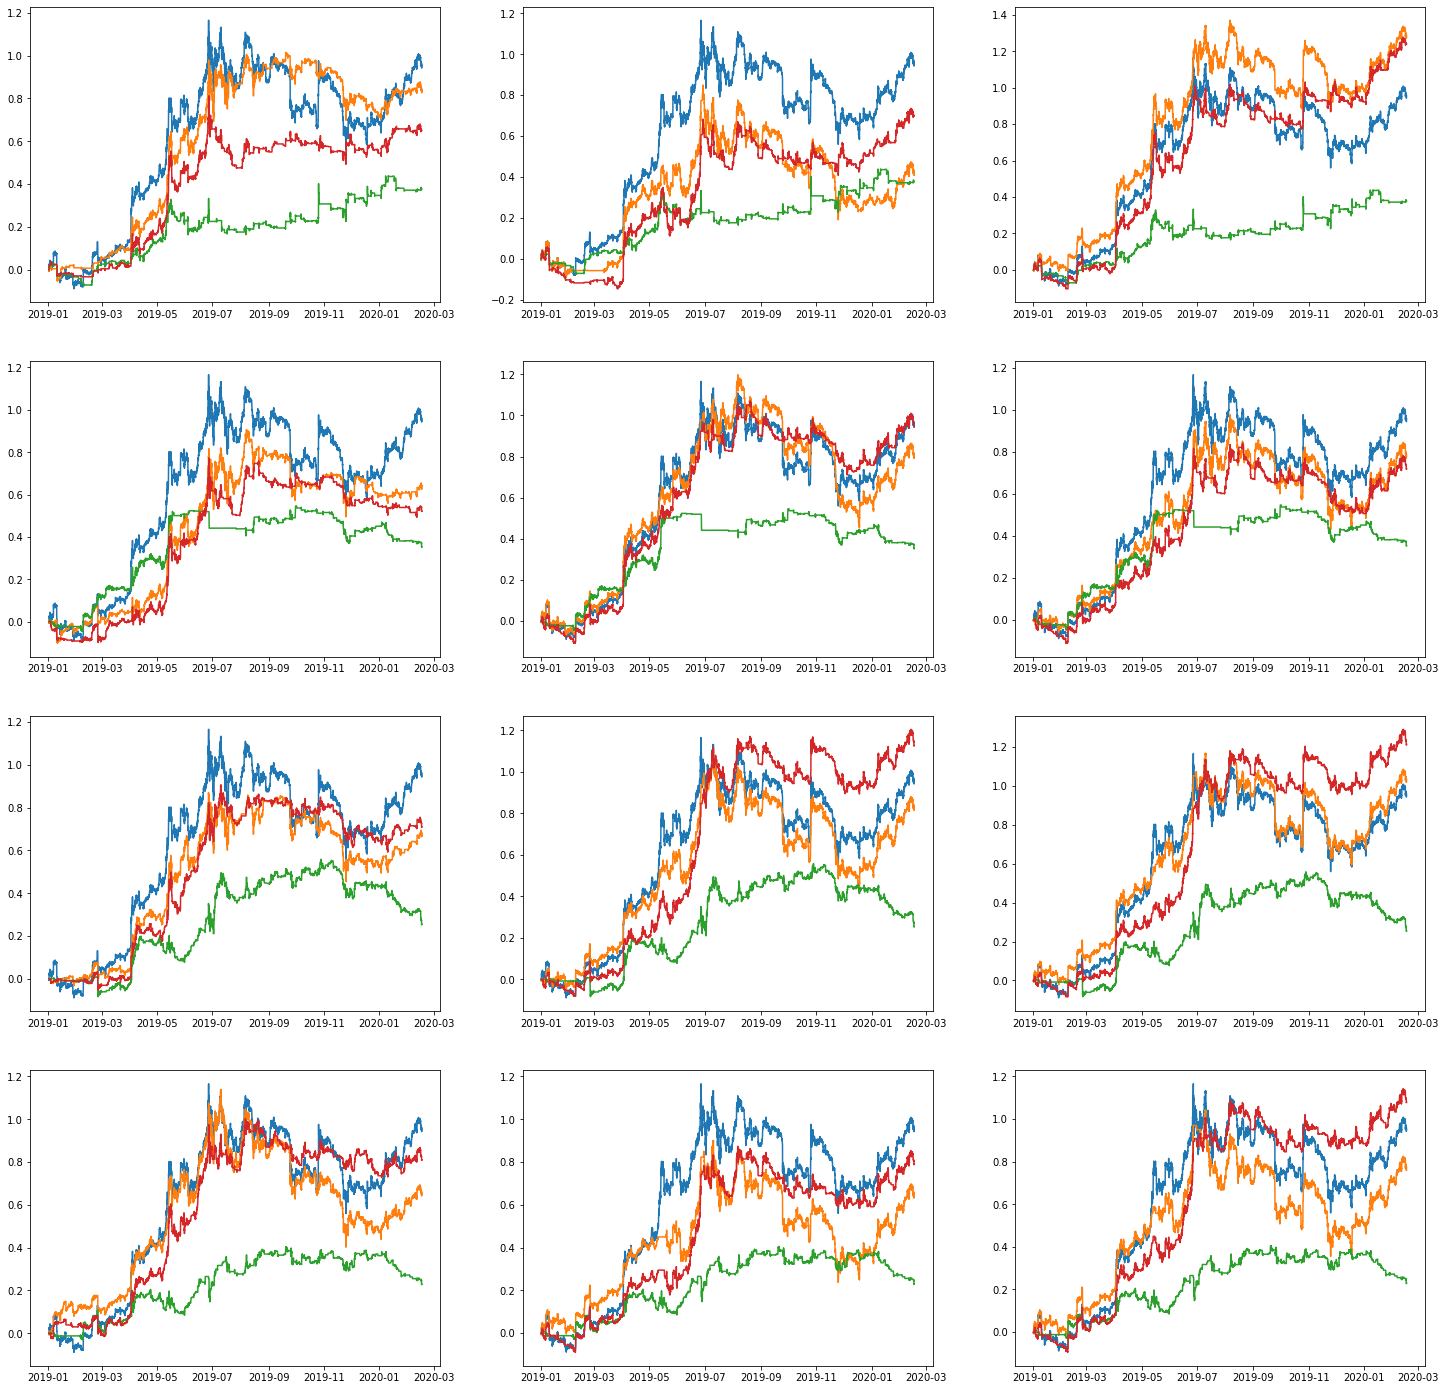

In [3]:
fig, axs = plt.subplots(4, 3, figsize=(25,25))
qs = qs_from_name(qs_name)
for i,q in enumerate(qs_name):
    for j,w in enumerate(ws_name):
        axs[i,j].plot(compdf['returns'].cumsum(), label = 'btc')
        returns = (compdf[['ret_ensemble_%s_0.%s' % (w, q), 'ret_varspread_%s_0.%s' % (w, q)]] * weights[['ensemble', 'varspread']].values).sum(1)
        axs[i,j].plot(compdf['ret_ensemble_%s_0.%s' % (w, q)].cumsum(), label = 'ensemble q:%s w:%s' % (q, w))
        axs[i,j].plot(compdf['ret_varspread_%s_0.%s' % (w, q)].cumsum(), label = 'varspread q:%s w:%s' % (q, w))
        """axs[i,j].plot(compdf[['ret_ensemble_%s_0.%s' % (w, q), 'ret_varspread_%s_0.%s' % (w, q)]].mean(1).cumsum(),
                 label = 'mean q:%s w:%s' % (q, w))
        """
        axs[i,j].plot(returns.cumsum(),
                     label = 'port q:%s w:%s' % (q, w))
        compdf['ret_switch_%s_0.%s' % (w, q)] = returns.values
        if legend:
            axs[i,j].legend()

if save:
    plt.savefig('./strat_switch_ens_varspread.png', bbox_inches='tight')
